In [126]:
import matplotlib.pyplot as plt

import torch
import torchaudio

In [127]:
import math
import warnings
from typing import Optional

import torch
from torch import Tensor


def _dB2Linear(x: float) -> float:
    return math.exp(x * math.log(10) / 20.0)


def _generate_wave_table(
    wave_type: str,
    data_type: str,
    table_size: int,
    min: float,
    max: float,
    phase: float,
    device: torch.device,
) -> Tensor:
    r"""A helper function for phaser. Generates a table with given parameters.

    Args:
        wave_type (str): SINE or TRIANGULAR
        data_type (str): desired data_type ( `INT` or `FLOAT` )
        table_size (int): desired table size
        min (float): desired min value
        max (float): desired max value
        phase (float): desired phase
        device (torch.device): Torch device on which table must be generated
    Returns:
        Tensor: A 1D tensor with wave table values
    """

    phase_offset = int(phase / math.pi / 2 * table_size + 0.5)

    t = torch.arange(table_size, device=device, dtype=torch.int32)

    point = (t + phase_offset) % table_size

    d = torch.zeros_like(point, device=device, dtype=torch.float64)

    if wave_type == "SINE":
        d = (torch.sin(point.to(torch.float64) / table_size * 2 * math.pi) + 1) / 2
    elif wave_type == "TRIANGLE":
        d = point.to(torch.float64) * 2 / table_size
        value = torch.div(4 * point, table_size, rounding_mode="floor")
        d[value == 0] = d[value == 0] + 0.5
        d[value == 1] = 1.5 - d[value == 1]
        d[value == 2] = 1.5 - d[value == 2]
        d[value == 3] = d[value == 3] - 1.5

    d = d * (max - min) + min

    if data_type == "INT":
        mask = d < 0
        d[mask] = d[mask] - 0.5
        d[~mask] = d[~mask] + 0.5
        d = d.to(torch.int32)
    elif data_type == "FLOAT":
        d = d.to(torch.float32)

    return d


def allpass_biquad(waveform: Tensor, sample_rate: int, central_freq: float, Q: float = 0.707) -> Tensor:
    r"""Design two-pole all-pass filter.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform(torch.Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        central_freq (float or torch.Tensor): central frequency (in Hz)
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    dtype = waveform.dtype
    device = waveform.device
    central_freq = torch.as_tensor(central_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)

    w0 = 2 * math.pi * central_freq / sample_rate

    alpha = torch.sin(w0) / 2 / Q

    b0 = 1 - alpha
    b1 = -2 * torch.cos(w0)
    b2 = 1 + alpha
    a0 = 1 + alpha
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha
    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def band_biquad(
    waveform: Tensor,
    sample_rate: int,
    central_freq: float,
    Q: float = 0.707,
    noise: bool = False,
) -> Tensor:
    r"""Design two-pole band filter.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        central_freq (float or torch.Tensor): central frequency (in Hz)
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``).
        noise (bool, optional) : If ``True``, uses the alternate mode for un-pitched audio (e.g. percussion).
            If ``False``, uses mode oriented to pitched audio, i.e. voice, singing,
            or instrumental music (Default: ``False``).

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    dtype = waveform.dtype
    device = waveform.device
    central_freq = torch.as_tensor(central_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)

    w0 = 2 * math.pi * central_freq / sample_rate
    bw_Hz = central_freq / Q

    a0 = 1.0
    a2 = torch.exp(-2 * math.pi * bw_Hz / sample_rate)
    a1 = -4 * a2 / (1 + a2) * torch.cos(w0)

    b0 = torch.sqrt(1 - a1 * a1 / (4 * a2)) * (1 - a2)

    if noise:
        mult = torch.sqrt(((1 + a2) * (1 + a2) - a1 * a1) * (1 - a2) / (1 + a2)) / b0
        b0 = mult * b0

    b1 = 0.0
    b2 = 0.0

    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def bandpass_biquad(
    waveform: Tensor,
    sample_rate: int,
    central_freq: float,
    Q: float = 0.707,
    const_skirt_gain: bool = False,
) -> Tensor:
    r"""Design two-pole band-pass filter.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        central_freq (float or torch.Tensor): central frequency (in Hz)
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)
        const_skirt_gain (bool, optional) : If ``True``, uses a constant skirt gain (peak gain = Q).
            If ``False``, uses a constant 0dB peak gain. (Default: ``False``)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    dtype = waveform.dtype
    device = waveform.device
    central_freq = torch.as_tensor(central_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)

    w0 = 2 * math.pi * central_freq / sample_rate
    alpha = torch.sin(w0) / 2 / Q

    temp = torch.sin(w0) / 2 if const_skirt_gain else alpha
    b0 = temp
    b1 = 0.0
    b2 = -temp
    a0 = 1 + alpha
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha
    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def bandreject_biquad(waveform: Tensor, sample_rate: int, central_freq: float, Q: float = 0.707) -> Tensor:
    r"""Design two-pole band-reject filter.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        central_freq (float or torch.Tensor): central frequency (in Hz)
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    dtype = waveform.dtype
    device = waveform.device
    central_freq = torch.as_tensor(central_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)

    w0 = 2 * math.pi * central_freq / sample_rate
    alpha = torch.sin(w0) / 2 / Q

    b0 = 1.0
    b1 = -2 * torch.cos(w0)
    b2 = 1.0
    a0 = 1 + alpha
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha
    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def bass_biquad(
    waveform: Tensor,
    sample_rate: int,
    gain: float,
    central_freq: float = 100,
    Q: float = 0.707,
) -> Tensor:
    r"""Design a bass tone-control effect.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        gain (float or torch.Tensor): desired gain at the boost (or attenuation) in dB.
        central_freq (float or torch.Tensor, optional): central frequency (in Hz). (Default: ``100``)
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``).

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    dtype = waveform.dtype
    device = waveform.device
    central_freq = torch.as_tensor(central_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)
    gain = torch.as_tensor(gain, dtype=dtype, device=device)

    w0 = 2 * math.pi * central_freq / sample_rate
    alpha = torch.sin(w0) / 2 / Q
    A = torch.exp(gain / 40 * math.log(10))

    temp1 = 2 * torch.sqrt(A) * alpha
    temp2 = (A - 1) * torch.cos(w0)
    temp3 = (A + 1) * torch.cos(w0)

    b0 = A * ((A + 1) - temp2 + temp1)
    b1 = 2 * A * ((A - 1) - temp3)
    b2 = A * ((A + 1) - temp2 - temp1)
    a0 = (A + 1) + temp2 + temp1
    a1 = -2 * ((A - 1) + temp3)
    a2 = (A + 1) + temp2 - temp1

    return biquad(waveform, b0 / a0, b1 / a0, b2 / a0, a0 / a0, a1 / a0, a2 / a0)


def biquad(waveform: Tensor, b0: float, b1: float, b2: float, a0: float, a1: float, a2: float) -> Tensor:
    r"""Perform a biquad filter of input tensor.  Initial conditions set to 0.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        b0 (float or torch.Tensor): numerator coefficient of current input, x[n]
        b1 (float or torch.Tensor): numerator coefficient of input one time step ago x[n-1]
        b2 (float or torch.Tensor): numerator coefficient of input two time steps ago x[n-2]
        a0 (float or torch.Tensor): denominator coefficient of current output y[n], typically 1
        a1 (float or torch.Tensor): denominator coefficient of current output y[n-1]
        a2 (float or torch.Tensor): denominator coefficient of current output y[n-2]

    Returns:
        Tensor: Waveform with dimension of `(..., time)`

    Reference:
       - https://en.wikipedia.org/wiki/Digital_biquad_filter
    """

    device = waveform.device
    dtype = waveform.dtype

    b0 = torch.as_tensor(b0, dtype=dtype, device=device).view(1)
    b1 = torch.as_tensor(b1, dtype=dtype, device=device).view(1)
    b2 = torch.as_tensor(b2, dtype=dtype, device=device).view(1)
    a0 = torch.as_tensor(a0, dtype=dtype, device=device).view(1)
    a1 = torch.as_tensor(a1, dtype=dtype, device=device).view(1)
    a2 = torch.as_tensor(a2, dtype=dtype, device=device).view(1)

    output_waveform = lfilter(
        waveform,
        torch.cat([a0, a1, a2]),
        torch.cat([b0, b1, b2]),
    )
    return output_waveform


def contrast(waveform: Tensor, enhancement_amount: float = 75.0) -> Tensor:
    r"""Apply contrast effect.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Comparable with compression, this effect modifies an audio signal to make it sound louder

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        enhancement_amount (float, optional): controls the amount of the enhancement
            Allowed range of values for enhancement_amount : 0-100
            Note that enhancement_amount = 0 still gives a significant contrast enhancement

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
    """

    if not 0 <= enhancement_amount <= 100:
        raise ValueError("Allowed range of values for enhancement_amount : 0-100")

    contrast = enhancement_amount / 750.0

    temp1 = waveform * (math.pi / 2)
    temp2 = contrast * torch.sin(temp1 * 4)
    output_waveform = torch.sin(temp1 + temp2)

    return output_waveform


def dcshift(waveform: Tensor, shift: float, limiter_gain: Optional[float] = None) -> Tensor:
    r"""Apply a DC shift to the audio. Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: TorchScript

    This can be useful to remove a DC offset
    (caused perhaps by a hardware problem in the recording chain) from the audio

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        shift (float): indicates the amount to shift the audio
            Allowed range of values for shift : -2.0 to +2.0
        limiter_gain (float of None, optional): It is used only on peaks to prevent clipping
            It should have a value much less than 1 (e.g. 0.05 or 0.02)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
    """
    output_waveform = waveform
    limiter_threshold = 0.0

    if limiter_gain is not None:
        limiter_threshold = 1.0 - (abs(shift) - limiter_gain)

    # Note:
    # the following index-based update breaks auto-grad support
    if limiter_gain is not None and shift > 0:
        mask = waveform > limiter_threshold
        temp = (waveform[mask] - limiter_threshold) * limiter_gain / (1 - limiter_threshold)
        output_waveform[mask] = (temp + limiter_threshold + shift).clamp(max=limiter_threshold)
        output_waveform[~mask] = (waveform[~mask] + shift).clamp(min=-1, max=1)
    elif limiter_gain is not None and shift < 0:
        mask = waveform < -limiter_threshold
        temp = (waveform[mask] + limiter_threshold) * limiter_gain / (1 - limiter_threshold)
        output_waveform[mask] = (temp - limiter_threshold + shift).clamp(min=-limiter_threshold)
        output_waveform[~mask] = (waveform[~mask] + shift).clamp(min=-1, max=1)
    else:
        output_waveform = (waveform + shift).clamp(min=-1, max=1)

    return output_waveform


def deemph_biquad(waveform: Tensor, sample_rate: int) -> Tensor:
    r"""Apply ISO 908 CD de-emphasis (shelving) IIR filter.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, Allowed sample rate ``44100`` or ``48000``

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """

    if sample_rate == 44100:
        central_freq = 5283
        width_slope = 0.4845
        gain = -9.477
    elif sample_rate == 48000:
        central_freq = 5356
        width_slope = 0.479
        gain = -9.62
    else:
        raise ValueError("Sample rate must be 44100 (audio-CD) or 48000 (DAT)")

    w0 = 2 * math.pi * central_freq / sample_rate
    A = math.exp(gain / 40.0 * math.log(10))
    alpha = math.sin(w0) / 2 * math.sqrt((A + 1 / A) * (1 / width_slope - 1) + 2)

    temp1 = 2 * math.sqrt(A) * alpha
    temp2 = (A - 1) * math.cos(w0)
    temp3 = (A + 1) * math.cos(w0)

    b0 = A * ((A + 1) + temp2 + temp1)
    b1 = -2 * A * ((A - 1) + temp3)
    b2 = A * ((A + 1) + temp2 - temp1)
    a0 = (A + 1) - temp2 + temp1
    a1 = 2 * ((A - 1) - temp3)
    a2 = (A + 1) - temp2 - temp1

    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def _add_noise_shaping(dithered_waveform: Tensor, waveform: Tensor) -> Tensor:
    r"""Noise shaping is calculated by error:
    error[n] = dithered[n] - original[n]
    noise_shaped_waveform[n] = dithered[n] + error[n-1]
    """
    wf_shape = waveform.size()
    waveform = waveform.reshape(-1, wf_shape[-1])

    dithered_shape = dithered_waveform.size()
    dithered_waveform = dithered_waveform.reshape(-1, dithered_shape[-1])

    error = dithered_waveform - waveform

    # add error[n-1] to dithered_waveform[n], so offset the error by 1 index
    zeros = torch.zeros(1, dtype=error.dtype, device=error.device)
    for index in range(error.size()[0]):
        err = error[index]
        error_offset = torch.cat((zeros, err))
        error[index] = error_offset[: waveform.size()[1]]

    noise_shaped = dithered_waveform + error
    return noise_shaped.reshape(dithered_shape[:-1] + noise_shaped.shape[-1:])


def _apply_probability_distribution(waveform: Tensor, density_function: str = "TPDF") -> Tensor:
    r"""Apply a probability distribution function on a waveform.

    Triangular probability density function (TPDF) dither noise has a
    triangular distribution; values in the center of the range have a higher
    probability of occurring.

    Rectangular probability density function (RPDF) dither noise has a
    uniform distribution; any value in the specified range has the same
    probability of occurring.

    Gaussian probability density function (GPDF) has a normal distribution.
    The relationship of probabilities of results follows a bell-shaped,
    or Gaussian curve, typical of dither generated by analog sources.
    Args:
        waveform (Tensor): Tensor of audio of dimension (..., time)
        density_function (str, optional): The density function of a
           continuous random variable (Default: ``"TPDF"``)
           Options: Triangular Probability Density Function - `TPDF`
                    Rectangular Probability Density Function - `RPDF`
                    Gaussian Probability Density Function - `GPDF`
    Returns:
        Tensor: waveform dithered with TPDF
    """

    # pack batch
    shape = waveform.size()
    waveform = waveform.reshape(-1, shape[-1])

    channel_size = waveform.size()[0] - 1
    time_size = waveform.size()[-1] - 1

    random_channel = (
        int(
            torch.randint(
                channel_size,
                [
                    1,
                ],
            ).item()
        )
        if channel_size > 0
        else 0
    )
    random_time = (
        int(
            torch.randint(
                time_size,
                [
                    1,
                ],
            ).item()
        )
        if time_size > 0
        else 0
    )

    number_of_bits = 16
    up_scaling = 2 ** (number_of_bits - 1) - 2
    signal_scaled = waveform * up_scaling
    down_scaling = 2 ** (number_of_bits - 1)

    signal_scaled_dis = waveform
    if density_function == "RPDF":
        RPDF = waveform[random_channel][random_time] - 0.5

        signal_scaled_dis = signal_scaled + RPDF
    elif density_function == "GPDF":
        # TODO Replace by distribution code once
        # https://github.com/pytorch/pytorch/issues/29843 is resolved
        # gaussian = torch.distributions.normal.Normal(torch.mean(waveform, -1), 1).sample()

        num_rand_variables = 6

        gaussian = waveform[random_channel][random_time]
        for ws in num_rand_variables * [time_size]:
            rand_chan = int(
                torch.randint(
                    channel_size,
                    [
                        1,
                    ],
                ).item()
            )
            gaussian += waveform[rand_chan][
                int(
                    torch.randint(
                        ws,
                        [
                            1,
                        ],
                    ).item()
                )
            ]

        signal_scaled_dis = signal_scaled + gaussian
    else:
        # dtype needed for https://github.com/pytorch/pytorch/issues/32358
        TPDF = torch.bartlett_window(time_size + 1, dtype=signal_scaled.dtype, device=signal_scaled.device)
        TPDF = TPDF.repeat((channel_size + 1), 1)
        signal_scaled_dis = signal_scaled + TPDF

    quantised_signal_scaled = torch.round(signal_scaled_dis)
    quantised_signal = quantised_signal_scaled / down_scaling

    # unpack batch
    return quantised_signal.reshape(shape[:-1] + quantised_signal.shape[-1:])


def dither(waveform: Tensor, density_function: str = "TPDF", noise_shaping: bool = False) -> Tensor:
    r"""Apply dither

    .. devices:: CPU CUDA

    .. properties:: TorchScript

    Dither increases the perceived dynamic range of audio stored at a
    particular bit-depth by eliminating nonlinear truncation distortion
    (i.e. adding minimally perceived noise to mask distortion caused by quantization).

    Args:
        waveform (Tensor): Tensor of audio of dimension (..., time)
        density_function (str, optional):
            The density function of a continuous random variable. One of
            ``"TPDF"`` (Triangular Probability Density Function),
            ``"RPDF"`` (Rectangular Probability Density Function) or
            ``"GPDF"`` (Gaussian Probability Density Function) (Default: ``"TPDF"``).
        noise_shaping (bool, optional): a filtering process that shapes the spectral
            energy of quantisation error (Default: ``False``)

    Returns:
       Tensor: waveform dithered
    """
    dithered = _apply_probability_distribution(waveform, density_function=density_function)

    if noise_shaping:
        return _add_noise_shaping(dithered, waveform)
    else:
        return dithered


def equalizer_biquad(
    waveform: Tensor,
    sample_rate: int,
    center_freq: float,
    gain: float,
    Q: float = 0.707,
) -> Tensor:
    r"""Design biquad peaking equalizer filter and perform filtering.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        center_freq (float): filter's central frequency
        gain (float or torch.Tensor): desired gain at the boost (or attenuation) in dB
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`
    """
    dtype = waveform.dtype
    device = waveform.device
    center_freq = torch.as_tensor(center_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)
    gain = torch.as_tensor(gain, dtype=dtype, device=device)

    w0 = 2 * math.pi * center_freq / sample_rate
    A = torch.exp(gain / 40.0 * math.log(10))
    alpha = torch.sin(w0) / 2 / Q

    b0 = 1 + alpha * A
    b1 = -2 * torch.cos(w0)
    b2 = 1 - alpha * A
    a0 = 1 + alpha / A
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha / A
    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def filtfilt(
    waveform: Tensor,
    a_coeffs: Tensor,
    b_coeffs: Tensor,
    clamp: bool = True,
) -> Tensor:
    r"""Apply an IIR filter forward and backward to a waveform.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Inspired by https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`.  Must be normalized to -1 to 1.
        a_coeffs (Tensor): denominator coefficients of difference equation of dimension of either
                                1D with shape `(num_order + 1)` or 2D with shape `(num_filters, num_order + 1)`.
                                Lower delay coefficients are first, e.g. ``[a0, a1, a2, ...]``.
                                Must be same size as b_coeffs (pad with 0's as necessary).
        b_coeffs (Tensor): numerator coefficients of difference equation of dimension of either
                                1D with shape `(num_order + 1)` or 2D with shape `(num_filters, num_order + 1)`.
                                Lower delay coefficients are first, e.g. ``[b0, b1, b2, ...]``.
                                Must be same size as a_coeffs (pad with 0's as necessary).
        clamp (bool, optional): If ``True``, clamp the output signal to be in the range [-1, 1] (Default: ``True``)

    Returns:
        Tensor: Waveform with dimension of either `(..., num_filters, time)` if ``a_coeffs`` and ``b_coeffs``
        are 2D Tensors, or `(..., time)` otherwise.
    """
    forward_filtered = lfilter(waveform, a_coeffs, b_coeffs, clamp=False, batching=True)
    backward_filtered = lfilter(
        forward_filtered.flip(-1),
        a_coeffs,
        b_coeffs,
        clamp=clamp,
        batching=True,
    ).flip(-1)
    return backward_filtered


def flanger(
    waveform: Tensor,
    sample_rate: int,
    delay: float = 0.0,
    depth: float = 2.0,
    regen: float = 0.0,
    width: float = 71.0,
    speed: float = 0.5,
    phase: float = 25.0,
    modulation: str = "sinusoidal",
    interpolation: str = "linear",
) -> Tensor:
    r"""Apply a flanger effect to the audio. Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., channel, time)` .
            Max 4 channels allowed
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        delay (float, optional): desired delay in milliseconds(ms)
            Allowed range of values are 0 to 30
        depth (float, optional): desired delay depth in milliseconds(ms)
            Allowed range of values are 0 to 10
        regen (float, optional): desired regen(feedback gain) in dB
            Allowed range of values are -95 to 95
        width (float, optional):  desired width(delay gain) in dB
            Allowed range of values are 0 to 100
        speed (float, optional):  modulation speed in Hz
            Allowed range of values are 0.1 to 10
        phase (float, optional):  percentage phase-shift for multi-channel
            Allowed range of values are 0 to 100
        modulation (str, optional):  Use either "sinusoidal" or "triangular" modulation. (Default: ``sinusoidal``)
        interpolation (str, optional): Use either "linear" or "quadratic" for delay-line interpolation.
            (Default: ``linear``)

    Returns:
        Tensor: Waveform of dimension of `(..., channel, time)`

    Reference:
        - http://sox.sourceforge.net/sox.html

        - Scott Lehman, `Effects Explained`_,

    .. _Effects Explained:
        https://web.archive.org/web/20051125072557/http://www.harmony-central.com/Effects/effects-explained.html
    """

    if modulation not in ("sinusoidal", "triangular"):
        raise ValueError("Only 'sinusoidal' or 'triangular' modulation allowed")

    if interpolation not in ("linear", "quadratic"):
        raise ValueError("Only 'linear' or 'quadratic' interpolation allowed")

    actual_shape = waveform.shape
    device, dtype = waveform.device, waveform.dtype

    if actual_shape[-2] > 4:
        raise ValueError("Max 4 channels allowed")

    # convert to 3D (batch, channels, time)
    waveform = waveform.view(-1, actual_shape[-2], actual_shape[-1])

    # Scaling
    feedback_gain = regen / 100
    delay_gain = width / 100
    channel_phase = phase / 100
    delay_min = delay / 1000
    delay_depth = depth / 1000

    n_channels = waveform.shape[-2]

    if modulation == "sinusoidal":
        wave_type = "SINE"
    else:
        wave_type = "TRIANGLE"

    # Balance output:
    in_gain = 1.0 / (1 + delay_gain)
    delay_gain = delay_gain / (1 + delay_gain)

    # Balance feedback loop:
    delay_gain = delay_gain * (1 - abs(feedback_gain))

    delay_buf_length = int((delay_min + delay_depth) * sample_rate + 0.5)
    delay_buf_length = delay_buf_length + 2

    delay_bufs = torch.zeros(waveform.shape[0], n_channels, delay_buf_length, dtype=dtype, device=device)
    delay_last = torch.zeros(waveform.shape[0], n_channels, dtype=dtype, device=device)

    lfo_length = int(sample_rate / speed)

    table_min = math.floor(delay_min * sample_rate + 0.5)
    table_max = delay_buf_length - 2.0

    lfo = _generate_wave_table(
        wave_type=wave_type,
        data_type="FLOAT",
        table_size=lfo_length,
        min=float(table_min),
        max=float(table_max),
        phase=3 * math.pi / 2,
        device=device,
    )

    output_waveform = torch.zeros_like(waveform, dtype=dtype, device=device)

    delay_buf_pos = 0
    lfo_pos = 0
    channel_idxs = torch.arange(0, n_channels, device=device)

    for i in range(waveform.shape[-1]):

        delay_buf_pos = (delay_buf_pos + delay_buf_length - 1) % delay_buf_length

        cur_channel_phase = (channel_idxs * lfo_length * channel_phase + 0.5).to(torch.int64)
        delay_tensor = lfo[(lfo_pos + cur_channel_phase) % lfo_length]
        frac_delay = torch.frac(delay_tensor)
        delay_tensor = torch.floor(delay_tensor)

        int_delay = delay_tensor.to(torch.int64)

        temp = waveform[:, :, i]

        delay_bufs[:, :, delay_buf_pos] = temp + delay_last * feedback_gain

        delayed_0 = delay_bufs[:, channel_idxs, (delay_buf_pos + int_delay) % delay_buf_length]

        int_delay = int_delay + 1

        delayed_1 = delay_bufs[:, channel_idxs, (delay_buf_pos + int_delay) % delay_buf_length]

        int_delay = int_delay + 1

        if interpolation == "linear":
            delayed = delayed_0 + (delayed_1 - delayed_0) * frac_delay
        else:
            delayed_2 = delay_bufs[:, channel_idxs, (delay_buf_pos + int_delay) % delay_buf_length]

            int_delay = int_delay + 1

            delayed_2 = delayed_2 - delayed_0
            delayed_1 = delayed_1 - delayed_0
            a = delayed_2 * 0.5 - delayed_1
            b = delayed_1 * 2 - delayed_2 * 0.5

            delayed = delayed_0 + (a * frac_delay + b) * frac_delay

        delay_last = delayed
        output_waveform[:, :, i] = waveform[:, :, i] * in_gain + delayed * delay_gain

        lfo_pos = (lfo_pos + 1) % lfo_length

    return output_waveform.clamp(min=-1, max=1).view(actual_shape)


def gain(waveform: Tensor, gain_db: float = 1.0) -> Tensor:
    r"""Apply amplification or attenuation to the whole waveform.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
       waveform (Tensor): Tensor of audio of dimension (..., time).
       gain_db (float, optional) Gain adjustment in decibels (dB) (Default: ``1.0``).

    Returns:
       Tensor: the whole waveform amplified by gain_db.
    """
    if gain_db == 0:
        return waveform

    ratio = 10 ** (gain_db / 20)

    return waveform * ratio


def highpass_biquad(waveform: Tensor, sample_rate: int, cutoff_freq: float, Q: float = 0.707) -> Tensor:
    r"""Design biquad highpass filter and perform filtering.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        cutoff_freq (float or torch.Tensor): filter cutoff frequency
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

    Returns:
        Tensor: Waveform dimension of `(..., time)`
    """
    dtype = waveform.dtype
    device = waveform.device
    cutoff_freq = torch.as_tensor(cutoff_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)

    w0 = 2 * math.pi * cutoff_freq / sample_rate
    alpha = torch.sin(w0) / 2.0 / Q

    b0 = (1 + torch.cos(w0)) / 2
    b1 = -1 - torch.cos(w0)
    b2 = b0
    a0 = 1 + alpha
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha
    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def _lfilter_core_generic_loop(input_signal_windows: Tensor, a_coeffs_flipped: Tensor, padded_output_waveform: Tensor):
    n_order = a_coeffs_flipped.size(1)
    a_coeffs_flipped = a_coeffs_flipped.unsqueeze(2)
    for i_sample, o0 in enumerate(input_signal_windows.permute(2, 0, 1)):
        windowed_output_signal = padded_output_waveform[:, :, i_sample: i_sample + n_order]
        o0 -= (windowed_output_signal.transpose(0, 1) @ a_coeffs_flipped)[..., 0].t()
        padded_output_waveform[:, :, i_sample + n_order - 1] = o0


try:
    _lfilter_core_cpu_loop = torch.ops.torchaudio._lfilter_core_loop
except RuntimeError as err:
    assert str(err) == "No such operator torchaudio::_lfilter_core_loop"
    _lfilter_core_cpu_loop = _lfilter_core_generic_loop


def _lfilter_core(
    waveform: Tensor,
    a_coeffs: Tensor,
    b_coeffs: Tensor,
) -> Tensor:

    assert a_coeffs.size() == b_coeffs.size()
    assert len(waveform.size()) == 3
    assert waveform.device == a_coeffs.device
    assert b_coeffs.device == a_coeffs.device

    n_batch, n_channel, n_sample = waveform.size()
    n_order = a_coeffs.size(1)
    assert n_order > 0

    # Pad the input and create output

    padded_waveform = torch.nn.functional.pad(waveform, [n_order - 1, 0])
    padded_output_waveform = torch.zeros_like(padded_waveform)

    # Set up the coefficients matrix
    # Flip coefficients' order
    a_coeffs_flipped = a_coeffs.flip(1)
    b_coeffs_flipped = b_coeffs.flip(1)

    # calculate windowed_input_signal in parallel using convolution
    input_signal_windows = torch.nn.functional.conv1d(padded_waveform, b_coeffs_flipped.unsqueeze(1), groups=n_channel)

    input_signal_windows.div_(a_coeffs[:, :1])
    a_coeffs_flipped.div_(a_coeffs[:, :1])

    if (
        input_signal_windows.device == torch.device("cpu")
        and a_coeffs_flipped.device == torch.device("cpu")
        and padded_output_waveform.device == torch.device("cpu")
    ):
        _lfilter_core_cpu_loop(input_signal_windows, a_coeffs_flipped, padded_output_waveform)
    else:
        _lfilter_core_generic_loop(input_signal_windows, a_coeffs_flipped, padded_output_waveform)

    output = padded_output_waveform[:, :, n_order - 1:]
    return output


try:
    _lfilter = torch.ops.torchaudio._lfilter
except RuntimeError as err:
    assert str(err) == "No such operator torchaudio::_lfilter"
    _lfilter = _lfilter_core


def lfilter(waveform: Tensor, a_coeffs: Tensor, b_coeffs: Tensor, clamp: bool = True, batching: bool = True) -> Tensor:
    r"""Perform an IIR filter by evaluating difference equation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Note:
        To avoid numerical problems, small filter order is preferred.
        Using double precision could also minimize numerical precision errors.

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`.  Must be normalized to -1 to 1.
        a_coeffs (Tensor): denominator coefficients of difference equation of dimension of either
                                1D with shape `(num_order + 1)` or 2D with shape `(num_filters, num_order + 1)`.
                                Lower delays coefficients are first, e.g. ``[a0, a1, a2, ...]``.
                                Must be same size as b_coeffs (pad with 0's as necessary).
        b_coeffs (Tensor): numerator coefficients of difference equation of dimension of either
                                1D with shape `(num_order + 1)` or 2D with shape `(num_filters, num_order + 1)`.
                                Lower delays coefficients are first, e.g. ``[b0, b1, b2, ...]``.
                                Must be same size as a_coeffs (pad with 0's as necessary).
        clamp (bool, optional): If ``True``, clamp the output signal to be in the range [-1, 1] (Default: ``True``)
        batching (bool, optional): Effective only when coefficients are 2D. If ``True``, then waveform should be at
                                    least 2D, and the size of second axis from last should equals to ``num_filters``.
                                    The output can be expressed as ``output[..., i, :] = lfilter(waveform[..., i, :],
                                    a_coeffs[i], b_coeffs[i], clamp=clamp, batching=False)``. (Default: ``True``)

    Returns:
        Tensor: Waveform with dimension of either `(..., num_filters, time)` if ``a_coeffs`` and ``b_coeffs``
        are 2D Tensors, or `(..., time)` otherwise.
    """
    assert a_coeffs.size() == b_coeffs.size()
    assert a_coeffs.ndim <= 2

    if a_coeffs.ndim > 1:
        if batching:
            assert waveform.ndim > 1
            assert waveform.shape[-2] == a_coeffs.shape[0]
        else:
            waveform = torch.stack([waveform] * a_coeffs.shape[0], -2)
    else:
        a_coeffs = a_coeffs.unsqueeze(0)
        b_coeffs = b_coeffs.unsqueeze(0)

    # pack batch
    shape = waveform.size()
    waveform = waveform.reshape(-1, a_coeffs.shape[0], shape[-1])
    output = _lfilter(waveform, a_coeffs, b_coeffs)

    if clamp:
        output = torch.clamp(output, min=-1.0, max=1.0)

    # unpack batch
    output = output.reshape(shape[:-1] + output.shape[-1:])

    return output


def lowpass_biquad(waveform: Tensor, sample_rate: int, cutoff_freq: float, Q: float = 0.707) -> Tensor:
    r"""Design biquad lowpass filter and perform filtering.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (torch.Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        cutoff_freq (float or torch.Tensor): filter cutoff frequency
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`
    """
    dtype = waveform.dtype
    device = waveform.device
    cutoff_freq = torch.as_tensor(cutoff_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)

    w0 = 2 * math.pi * cutoff_freq / sample_rate
    alpha = torch.sin(w0) / 2 / Q

    b0 = (1 - torch.cos(w0)) / 2
    b1 = 1 - torch.cos(w0)
    b2 = b0
    a0 = 1 + alpha
    a1 = -2 * torch.cos(w0)
    a2 = 1 - alpha
    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def _overdrive_core_loop_generic(
    waveform: Tensor, temp: Tensor, last_in: Tensor, last_out: Tensor, output_waveform: Tensor
):
    for i in range(waveform.shape[-1]):
        last_out = temp[:, i] - last_in + 0.995 * last_out
        last_in = temp[:, i]
        output_waveform[:, i] = waveform[:, i] * 0.5 + last_out * 0.75


try:
    _overdrive_core_loop_cpu = torch.ops.torchaudio._overdrive_core_loop
except RuntimeError as err:
    assert str(err) == "No such operator torchaudio::_overdrive_core_loop"
    _overdrive_core_loop_cpu = _overdrive_core_loop_generic


def overdrive(waveform: Tensor, gain: float = 20, colour: float = 20) -> Tensor:
    r"""Apply a overdrive effect to the audio. Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    This effect applies a non linear distortion to the audio signal.

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        gain (float, optional): desired gain at the boost (or attenuation) in dB
            Allowed range of values are 0 to 100
        colour (float, optional):  controls the amount of even harmonic content in the over-driven output
            Allowed range of values are 0 to 100

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
    """
    actual_shape = waveform.shape
    device, dtype = waveform.device, waveform.dtype

    # convert to 2D (..,time)
    waveform = waveform.view(-1, actual_shape[-1])

    gain = _dB2Linear(gain)
    colour = colour / 200
    last_in = torch.zeros(waveform.shape[:-1], dtype=dtype, device=device)
    last_out = torch.zeros(waveform.shape[:-1], dtype=dtype, device=device)

    temp = waveform * gain + colour

    mask1 = temp < -1
    temp[mask1] = torch.tensor(-2.0 / 3.0, dtype=dtype, device=device)
    # Wrapping the constant with Tensor is required for Torchscript

    mask2 = temp > 1
    temp[mask2] = torch.tensor(2.0 / 3.0, dtype=dtype, device=device)

    mask3 = ~mask1 & ~mask2
    temp[mask3] = temp[mask3] - (temp[mask3] ** 3) * (1.0 / 3)

    output_waveform = torch.zeros_like(waveform, dtype=dtype, device=device)

    # Uses CPU optimized loop function if available for CPU device
    if device == torch.device("cpu"):
        _overdrive_core_loop_cpu(waveform, temp, last_in, last_out, output_waveform)
    else:
        _overdrive_core_loop_generic(waveform, temp, last_in, last_out, output_waveform)

    return output_waveform.clamp(min=-1, max=1).view(actual_shape)


def phaser(
    waveform: Tensor,
    sample_rate: int,
    gain_in: float = 0.4,
    gain_out: float = 0.74,
    delay_ms: float = 3.0,
    decay: float = 0.4,
    mod_speed: float = 0.5,
    sinusoidal: bool = True,
) -> Tensor:
    r"""Apply a phasing effect to the audio. Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        gain_in (float, optional): desired input gain at the boost (or attenuation) in dB
            Allowed range of values are 0 to 1
        gain_out (float, optional): desired output gain at the boost (or attenuation) in dB
            Allowed range of values are 0 to 1e9
        delay_ms (float, optional): desired delay in milliseconds
            Allowed range of values are 0 to 5.0
        decay (float, optional):  desired decay relative to gain-in
            Allowed range of values are 0 to 0.99
        mod_speed (float, optional):  modulation speed in Hz
            Allowed range of values are 0.1 to 2
        sinusoidal (bool, optional):  If ``True``, uses sinusoidal modulation (preferable for multiple instruments)
            If ``False``, uses triangular modulation (gives single instruments a sharper phasing effect)
            (Default: ``True``)

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - Scott Lehman, `Effects Explained`_.

    .. _Effects Explained:
        https://web.archive.org/web/20051125072557/http://www.harmony-central.com/Effects/effects-explained.html
    """
    actual_shape = waveform.shape
    device, dtype = waveform.device, waveform.dtype

    # convert to 2D (channels,time)
    waveform = waveform.view(-1, actual_shape[-1])

    delay_buf_len = int((delay_ms * 0.001 * sample_rate) + 0.5)
    delay_buf = torch.zeros(waveform.shape[0], delay_buf_len, dtype=dtype, device=device)

    mod_buf_len = int(sample_rate / mod_speed + 0.5)

    if sinusoidal:
        wave_type = "SINE"
    else:
        wave_type = "TRIANGLE"

    mod_buf = _generate_wave_table(
        wave_type=wave_type,
        data_type="INT",
        table_size=mod_buf_len,
        min=1.0,
        max=float(delay_buf_len),
        phase=math.pi / 2,
        device=device,
    )

    delay_pos = 0
    mod_pos = 0

    output_waveform_pre_gain_list = []
    waveform = waveform * gain_in
    delay_buf = delay_buf * decay
    waveform_list = [waveform[:, i] for i in range(waveform.size(1))]
    delay_buf_list = [delay_buf[:, i] for i in range(delay_buf.size(1))]
    mod_buf_list = [mod_buf[i] for i in range(mod_buf.size(0))]

    for i in range(waveform.shape[-1]):
        idx = int((delay_pos + mod_buf_list[mod_pos]) % delay_buf_len)
        mod_pos = (mod_pos + 1) % mod_buf_len
        delay_pos = (delay_pos + 1) % delay_buf_len
        temp = (waveform_list[i]) + (delay_buf_list[idx])
        delay_buf_list[delay_pos] = temp * decay
        output_waveform_pre_gain_list.append(temp)

    output_waveform = torch.stack(output_waveform_pre_gain_list, dim=1).to(dtype=dtype, device=device)
    output_waveform.mul_(gain_out)

    return output_waveform.clamp(min=-1, max=1).view(actual_shape)


def riaa_biquad(waveform: Tensor, sample_rate: int) -> Tensor:
    r"""Apply RIAA vinyl playback equalization.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz).
            Allowed sample rates in Hz : ``44100``,``48000``,``88200``,``96000``

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """

    if sample_rate == 44100:
        zeros = [-0.2014898, 0.9233820]
        poles = [0.7083149, 0.9924091]

    elif sample_rate == 48000:
        zeros = [-0.1766069, 0.9321590]
        poles = [0.7396325, 0.9931330]

    elif sample_rate == 88200:
        zeros = [-0.1168735, 0.9648312]
        poles = [0.8590646, 0.9964002]

    elif sample_rate == 96000:
        zeros = [-0.1141486, 0.9676817]
        poles = [0.8699137, 0.9966946]

    else:
        raise ValueError("Sample rate must be 44.1k, 48k, 88.2k, or 96k")

    # polynomial coefficients with roots zeros[0] and zeros[1]
    b0 = 1.0
    b1 = -(zeros[0] + zeros[1])
    b2 = zeros[0] * zeros[1]

    # polynomial coefficients with roots poles[0] and poles[1]
    a0 = 1.0
    a1 = -(poles[0] + poles[1])
    a2 = poles[0] * poles[1]

    # Normalize to 0dB at 1kHz
    y = 2 * math.pi * 1000 / sample_rate
    b_re = b0 + b1 * math.cos(-y) + b2 * math.cos(-2 * y)
    a_re = a0 + a1 * math.cos(-y) + a2 * math.cos(-2 * y)
    b_im = b1 * math.sin(-y) + b2 * math.sin(-2 * y)
    a_im = a1 * math.sin(-y) + a2 * math.sin(-2 * y)
    g = 1 / math.sqrt((b_re ** 2 + b_im ** 2) / (a_re ** 2 + a_im ** 2))

    b0 *= g
    b1 *= g
    b2 *= g

    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def treble_biquad(
    waveform: Tensor,
    sample_rate: int,
    gain: float,
    central_freq: float = 3000,
    Q: float = 0.707,
) -> Tensor:
    r"""Design a treble tone-control effect.  Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        gain (float or torch.Tensor): desired gain at the boost (or attenuation) in dB.
        central_freq (float or torch.Tensor, optional): central frequency (in Hz). (Default: ``3000``)
        Q (float or torch.Tensor, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``).

    Returns:
        Tensor: Waveform of dimension of `(..., time)`

    Reference:
        - http://sox.sourceforge.net/sox.html
        - https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    dtype = waveform.dtype
    device = waveform.device
    central_freq = torch.as_tensor(central_freq, dtype=dtype, device=device)
    Q = torch.as_tensor(Q, dtype=dtype, device=device)
    gain = torch.as_tensor(gain, dtype=dtype, device=device)

    w0 = 2 * math.pi * central_freq / sample_rate
    alpha = torch.sin(w0) / 2 / Q
    A = torch.exp(gain / 40 * math.log(10))

    temp1 = 2 * torch.sqrt(A) * alpha
    temp2 = (A - 1) * torch.cos(w0)
    temp3 = (A + 1) * torch.cos(w0)

    b0 = A * ((A + 1) + temp2 + temp1)
    b1 = -2 * A * ((A - 1) + temp3)
    b2 = A * ((A + 1) + temp2 - temp1)
    a0 = (A + 1) - temp2 + temp1
    a1 = 2 * ((A - 1) - temp3)
    a2 = (A + 1) - temp2 - temp1

    return biquad(waveform, b0, b1, b2, a0, a1, a2)


def _measure(
    measure_len_ws: int,
    samples: Tensor,
    spectrum: Tensor,
    noise_spectrum: Tensor,
    spectrum_window: Tensor,
    spectrum_start: int,
    spectrum_end: int,
    cepstrum_window: Tensor,
    cepstrum_start: int,
    cepstrum_end: int,
    noise_reduction_amount: float,
    measure_smooth_time_mult: float,
    noise_up_time_mult: float,
    noise_down_time_mult: float,
    index_ns: int,
    boot_count: int,
) -> float:

    assert spectrum.size()[-1] == noise_spectrum.size()[-1]

    samplesLen_ns = samples.size()[-1]
    dft_len_ws = spectrum.size()[-1]

    dftBuf = torch.zeros(dft_len_ws)

    _index_ns = torch.tensor([index_ns] + [(index_ns + i) % samplesLen_ns for i in range(1, measure_len_ws)])
    dftBuf[:measure_len_ws] = samples[_index_ns] * spectrum_window[:measure_len_ws]

    # memset(c->dftBuf + i, 0, (p->dft_len_ws - i) * sizeof(*c->dftBuf));
    dftBuf[measure_len_ws:dft_len_ws].zero_()

    # lsx_safe_rdft((int)p->dft_len_ws, 1, c->dftBuf);
    _dftBuf = torch.fft.rfft(dftBuf)

    # memset(c->dftBuf, 0, p->spectrum_start * sizeof(*c->dftBuf));
    _dftBuf[:spectrum_start].zero_()

    mult: float = boot_count / (1.0 + boot_count) if boot_count >= 0 else measure_smooth_time_mult

    _d = _dftBuf[spectrum_start:spectrum_end].abs()
    spectrum[spectrum_start:spectrum_end].mul_(mult).add_(_d * (1 - mult))
    _d = spectrum[spectrum_start:spectrum_end] ** 2

    _zeros = torch.zeros(spectrum_end - spectrum_start)
    _mult = (
        _zeros
        if boot_count >= 0
        else torch.where(
            _d > noise_spectrum[spectrum_start:spectrum_end],
            torch.tensor(noise_up_time_mult),  # if
            torch.tensor(noise_down_time_mult),  # else
        )
    )

    noise_spectrum[spectrum_start:spectrum_end].mul_(_mult).add_(_d * (1 - _mult))
    _d = torch.sqrt(
        torch.max(
            _zeros,
            _d - noise_reduction_amount * noise_spectrum[spectrum_start:spectrum_end],
        )
    )

    _cepstrum_Buf: Tensor = torch.zeros(dft_len_ws >> 1)
    _cepstrum_Buf[spectrum_start:spectrum_end] = _d * cepstrum_window
    _cepstrum_Buf[spectrum_end: dft_len_ws >> 1].zero_()

    # lsx_safe_rdft((int)p->dft_len_ws >> 1, 1, c->dftBuf);
    _cepstrum_Buf = torch.fft.rfft(_cepstrum_Buf)

    result: float = float(torch.sum(_cepstrum_Buf[cepstrum_start:cepstrum_end].abs().pow(2)))
    result = math.log(result / (cepstrum_end - cepstrum_start)) if result > 0 else -math.inf
    return max(0, 21 + result)


def vad(
    waveform: Tensor,
    sample_rate: int,
    trigger_level: float = 7.0,
    trigger_time: float = 0.25,
    search_time: float = 1.0,
    allowed_gap: float = 0.25,
    pre_trigger_time: float = 0.0,
    # Fine-tuning parameters
    boot_time: float = 0.35,
    noise_up_time: float = 0.1,
    noise_down_time: float = 0.01,
    noise_reduction_amount: float = 1.35,
    measure_freq: float = 20.0,
    measure_duration: Optional[float] = None,
    measure_smooth_time: float = 0.4,
    hp_filter_freq: float = 50.0,
    lp_filter_freq: float = 6000.0,
    hp_lifter_freq: float = 150.0,
    lp_lifter_freq: float = 2000.0,
) -> tuple[Tensor, int]:
    r"""Voice Activity Detector. Similar to SoX implementation.

    .. devices:: CPU CUDA

    .. properties:: TorchScript

    Attempts to trim silence and quiet background sounds from the ends of recordings of speech.
    The algorithm currently uses a simple cepstral power measurement to detect voice,
    so may be fooled by other things, especially music.

    The effect can trim only from the front of the audio,
    so in order to trim from the back, the reverse effect must also be used.

    Args:
        waveform (Tensor): Tensor of audio of dimension `(channels, time)` or `(time)`
            Tensor of shape `(channels, time)` is treated as a multi-channel recording
            of the same event and the resulting output will be trimmed to the earliest
            voice activity in any channel.
        sample_rate (int): Sample rate of audio signal.
        trigger_level (float, optional): The measurement level used to trigger activity detection.
            This may need to be cahnged depending on the noise level, signal level,
            and other characteristics of the input audio. (Default: 7.0)
        trigger_time (float, optional): The time constant (in seconds)
            used to help ignore short bursts of sound. (Default: 0.25)
        search_time (float, optional): The amount of audio (in seconds)
            to search for quieter/shorter bursts of audio to include prior
            to the detected trigger point. (Default: 1.0)
        allowed_gap (float, optional): The allowed gap (in seconds) between
            quieter/shorter bursts of audio to include prior
            to the detected trigger point. (Default: 0.25)
        pre_trigger_time (float, optional): The amount of audio (in seconds) to preserve
            before the trigger point and any found quieter/shorter bursts. (Default: 0.0)
        boot_time (float, optional) The algorithm (internally) uses adaptive noise
            estimation/reduction in order to detect the start of the wanted audio.
            This option sets the time for the initial noise estimate. (Default: 0.35)
        noise_up_time (float, optional) Time constant used by the adaptive noise estimator
            for when the noise level is increasing. (Default: 0.1)
        noise_down_time (float, optional) Time constant used by the adaptive noise estimator
            for when the noise level is decreasing. (Default: 0.01)
        noise_reduction_amount (float, optional) Amount of noise reduction to use in
            the detection algorithm (e.g. 0, 0.5, ...). (Default: 1.35)
        measure_freq (float, optional) Frequency of the algorithm’s
            processing/measurements. (Default: 20.0)
        measure_duration: (float, optional) Measurement duration.
            (Default: Twice the measurement period; i.e. with overlap.)
        measure_smooth_time (float, optional) Time constant used to smooth
            spectral measurements. (Default: 0.4)
        hp_filter_freq (float, optional) "Brick-wall" frequency of high-pass filter applied
            at the input to the detector algorithm. (Default: 50.0)
        lp_filter_freq (float, optional) "Brick-wall" frequency of low-pass filter applied
            at the input to the detector algorithm. (Default: 6000.0)
        hp_lifter_freq (float, optional) "Brick-wall" frequency of high-pass lifter used
            in the detector algorithm. (Default: 150.0)
        lp_lifter_freq (float, optional) "Brick-wall" frequency of low-pass lifter used
            in the detector algorithm. (Default: 2000.0)

    Returns:
        Tensor: Tensor of audio of dimension `(..., time)`.

    Reference:
        - http://sox.sourceforge.net/sox.html
    """

    if waveform.ndim > 2:
        warnings.warn(
            "Expected input tensor dimension of 1 for single channel"
            f" or 2 for multi-channel. Got {waveform.ndim} instead. "
            "Batch semantics is not supported. "
            "Please refer to https://github.com/pytorch/audio/issues/1348"
            " and https://github.com/pytorch/audio/issues/1468."
        )

    measure_duration: float = 2.0 / measure_freq if measure_duration is None else measure_duration

    measure_len_ws = int(sample_rate * measure_duration + 0.5)
    measure_len_ns = measure_len_ws
    # for (dft_len_ws = 16; dft_len_ws < measure_len_ws; dft_len_ws <<= 1);
    dft_len_ws = 16
    while dft_len_ws < measure_len_ws:
        dft_len_ws *= 2

    measure_period_ns = int(sample_rate / measure_freq + 0.5)
    measures_len = math.ceil(search_time * measure_freq)
    search_pre_trigger_len_ns = measures_len * measure_period_ns
    gap_len = int(allowed_gap * measure_freq + 0.5)

    fixed_pre_trigger_len_ns = int(pre_trigger_time * sample_rate + 0.5)
    samplesLen_ns = fixed_pre_trigger_len_ns + search_pre_trigger_len_ns + measure_len_ns

    spectrum_window = torch.zeros(measure_len_ws)
    for i in range(measure_len_ws):
        # sox.h:741 define SOX_SAMPLE_MIN (sox_sample_t)SOX_INT_MIN(32)
        spectrum_window[i] = 2.0 / math.sqrt(float(measure_len_ws))
    # lsx_apply_hann(spectrum_window, (int)measure_len_ws);
    spectrum_window *= torch.hann_window(measure_len_ws, dtype=torch.float)

    spectrum_start: int = int(hp_filter_freq / sample_rate * dft_len_ws + 0.5)
    spectrum_start: int = max(spectrum_start, 1)
    spectrum_end: int = int(lp_filter_freq / sample_rate * dft_len_ws + 0.5)
    spectrum_end: int = min(spectrum_end, dft_len_ws // 2)

    cepstrum_window = torch.zeros(spectrum_end - spectrum_start)
    for i in range(spectrum_end - spectrum_start):
        cepstrum_window[i] = 2.0 / math.sqrt(float(spectrum_end) - spectrum_start)
    # lsx_apply_hann(cepstrum_window,(int)(spectrum_end - spectrum_start));
    cepstrum_window *= torch.hann_window(spectrum_end - spectrum_start, dtype=torch.float)

    cepstrum_start = math.ceil(sample_rate * 0.5 / lp_lifter_freq)
    cepstrum_end = math.floor(sample_rate * 0.5 / hp_lifter_freq)
    cepstrum_end = min(cepstrum_end, dft_len_ws // 4)

    assert cepstrum_end > cepstrum_start

    noise_up_time_mult = math.exp(-1.0 / (noise_up_time * measure_freq))
    noise_down_time_mult = math.exp(-1.0 / (noise_down_time * measure_freq))
    measure_smooth_time_mult = math.exp(-1.0 / (measure_smooth_time * measure_freq))
    trigger_meas_time_mult = math.exp(-1.0 / (trigger_time * measure_freq))

    boot_count_max = int(boot_time * measure_freq - 0.5)
    measure_timer_ns = measure_len_ns
    boot_count = measures_index = flushedLen_ns = samplesIndex_ns = 0

    # pack batch
    shape = waveform.size()
    waveform = waveform.view(-1, shape[-1])

    n_channels, ilen = waveform.size()

    mean_meas = torch.zeros(n_channels)
    samples = torch.zeros(n_channels, samplesLen_ns)
    spectrum = torch.zeros(n_channels, dft_len_ws)
    noise_spectrum = torch.zeros(n_channels, dft_len_ws)
    measures = torch.zeros(n_channels, measures_len)

    has_triggered: bool = False
    num_measures_to_flush: int = 0
    pos: int = 0

    while pos < ilen and not has_triggered:
        measure_timer_ns -= 1
        for i in range(n_channels):
            samples[i, samplesIndex_ns] = waveform[i, pos]
            # if (!p->measure_timer_ns) {
            if measure_timer_ns == 0:
                index_ns: int = (samplesIndex_ns + samplesLen_ns - measure_len_ns) % samplesLen_ns
                meas: float = _measure(
                    measure_len_ws=measure_len_ws,
                    samples=samples[i],
                    spectrum=spectrum[i],
                    noise_spectrum=noise_spectrum[i],
                    spectrum_window=spectrum_window,
                    spectrum_start=spectrum_start,
                    spectrum_end=spectrum_end,
                    cepstrum_window=cepstrum_window,
                    cepstrum_start=cepstrum_start,
                    cepstrum_end=cepstrum_end,
                    noise_reduction_amount=noise_reduction_amount,
                    measure_smooth_time_mult=measure_smooth_time_mult,
                    noise_up_time_mult=noise_up_time_mult,
                    noise_down_time_mult=noise_down_time_mult,
                    index_ns=index_ns,
                    boot_count=boot_count,
                )
                measures[i, measures_index] = meas
                mean_meas[i] = mean_meas[i] * trigger_meas_time_mult + meas * (1.0 - trigger_meas_time_mult)

                has_triggered = has_triggered or (mean_meas[i] >= trigger_level)
                if has_triggered:
                    n: int = measures_len
                    k: int = measures_index
                    jTrigger: int = n
                    jZero: int = n
                    j: int = 0

                    for j in range(n):
                        if (measures[i, k] >= trigger_level) and (j <= jTrigger + gap_len):
                            jZero = jTrigger = j
                        elif (measures[i, k] == 0) and (jTrigger >= jZero):
                            jZero = j
                        k = (k + n - 1) % n
                    j = min(j, jZero)
                    # num_measures_to_flush = range_limit(j, num_measures_to_flush, n);
                    num_measures_to_flush = min(max(num_measures_to_flush, j), n)
                # end if has_triggered
            # end if (measure_timer_ns == 0):
        # end for
        samplesIndex_ns += 1
        pos += 1
        # end while
        if samplesIndex_ns == samplesLen_ns:
            samplesIndex_ns = 0
        if measure_timer_ns == 0:
            measure_timer_ns = measure_period_ns
            measures_index += 1
            measures_index = measures_index % measures_len
            if boot_count >= 0:
                boot_count = -1 if boot_count == boot_count_max else boot_count + 1

        if has_triggered:
            flushedLen_ns = (measures_len - num_measures_to_flush) * measure_period_ns
            samplesIndex_ns = (samplesIndex_ns + flushedLen_ns) % samplesLen_ns

    res = waveform[:, pos - samplesLen_ns + flushedLen_ns:]
    # unpack batch
    return res.view(shape[:-1] + res.shape[-1:]), pos - samplesLen_ns + flushedLen_ns

In [128]:
wav, sr = torchaudio.load("../dataSet/문제3/문제3-2.wav")
print(wav.shape, sr)

torch.Size([1, 53760]) 16000


In [129]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c + 1}")
    figure.suptitle("waveform")
    plt.show(block=False)

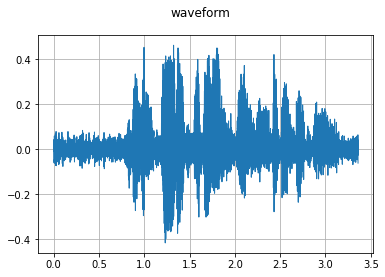

In [130]:
plot_waveform(wav, sr)

In [131]:
vad_wav, begin_idx = vad(wav, sr)
vad_wav, reverse_begin_idx = vad(vad_wav.flip(dims=[-1]), sr)
vad_wav = vad_wav.flip(dims=[-1])
torch.all(vad_wav == wav[:, begin_idx:-reverse_begin_idx])

print(begin_idx, wav.shape[-1] - reverse_begin_idx, wav.shape[-1])

10400 48960 53760


In [132]:
# torchaudio.save("문제3-2_vad.wav", vad_wav, sr)